## Task 2

### Task 2 - A: Data import / pre-processing

1. Import data
2. Split data to train, validation, test sets (shuffle, rate)
3. Pre-processing, ig. normalization (why do it)

#### Data Importing and Extraction

In [1]:
# Load the data from Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tqdm

In [3]:
import os
import random
from tqdm import tqdm
import numpy as np

In [4]:
# first unzip the .zip file. '-q' keep verbose, not print the process
!unzip -q /content/drive/MyDrive/Machine_Learning_UoA/soybean_images.zip

After unzipped, we can see there is a new folder in our current work directory named `syobean_images`. The images are stored
in this directory.

In [5]:
def extract_data(directory):
    """get the numpy.ndarray data of images and labels"""
    images = [np.load(directory+str(f))['image'] for f in tqdm(os.listdir(directory))]
    labels = [np.load(directory+str(f))['y'] for f in tqdm(os.listdir(directory))]
    return np.asarray(images, dtype='float32'), np.asarray(labels, dtype='float32')

In [6]:
# extract the images and labels
sample_dir = './soybean_images/'
images, labels = extract_data(sample_dir)

# reshape labels as matrix
labels = labels.reshape(-1, 1)

# check the shape of variable image and labels
print(images.shape)
print(labels.shape)

100%|██████████| 22986/22986 [00:13<00:00, 1684.76it/s]


(22986, 9, 32, 32)
(22986, 1)


Here we can tell that we have $22986$ arrays in both images and labels, each array contains 9 infrared images scanned
by different infrared intensity. We can plot one of the images to see how's it look like.

*Note:* the image are generated by scanning of infrared ray, the pixels of image are very low (from 0 to 1), which means we can't
observe the image if we just simply convert numpy to RGB image. However, we can use Pycharm `sciview` or `matplotlib` to plot the image.

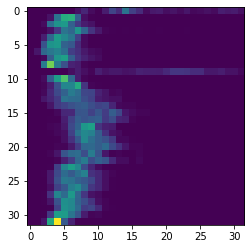

In [7]:
import matplotlib.pyplot as plt

# choose the first infrared image of first array to plot. An array contains 9 plots.
plt.imshow(images[0][0])

#### Normalization

The purpose of normalization is to scale the data features with a standard to accelerate convergence, accuracy, and preventing the gradient
explosion of the model. The preliminary idea is to scale all the values in the range of `[0-1]`. We will check the value range of
images to decide if we have to do data normalization.

In [8]:
# show max value of images
np.max(images)

1.0

In [9]:
# show min value of images
np.min(images)

0.0

In [10]:
import random

def plot_distribution(arrs):
    n = random.randint(1, 20000)
    for imgs in tqdm(arrs[n]):  # images[0]
        k = 1
        plt.figure(figsize=(20, 20))
        for img in imgs:    # images[0][0]
            plt.subplot(9, 32, k)
            plt.plot(img, range(1, 33))
            k+=1

100%|██████████| 9/9 [00:05<00:00,  1.77it/s]


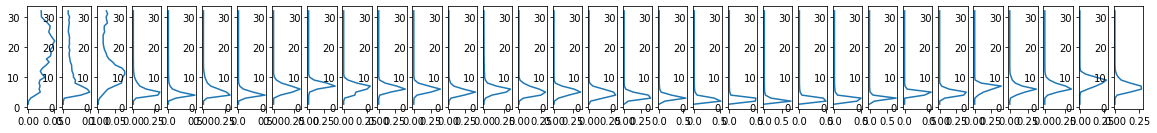

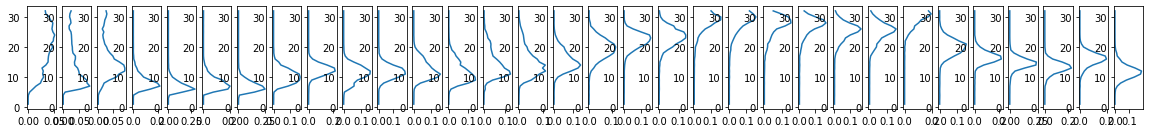

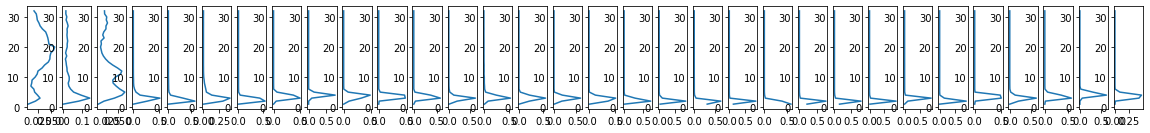

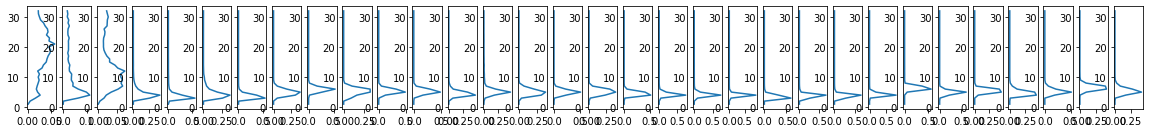

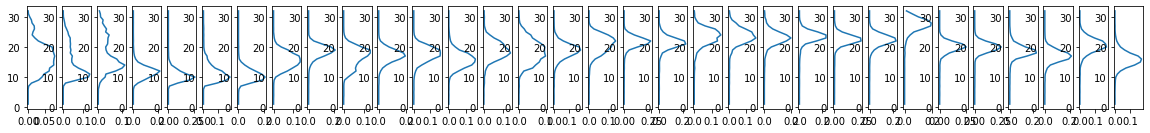

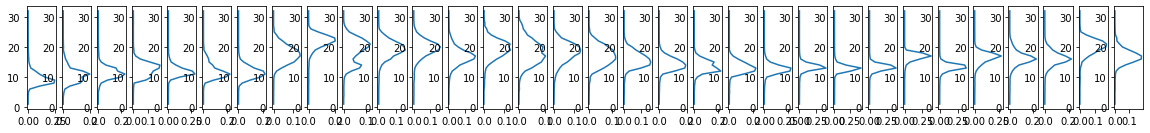

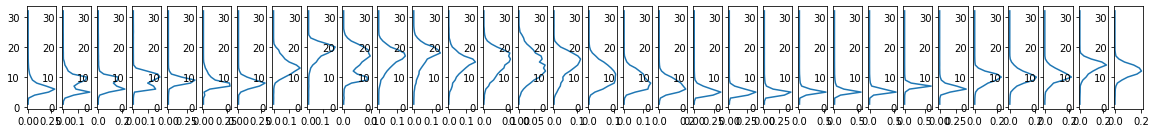

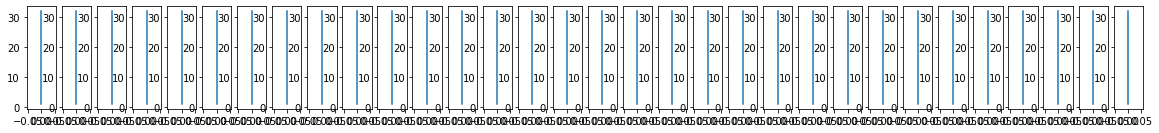

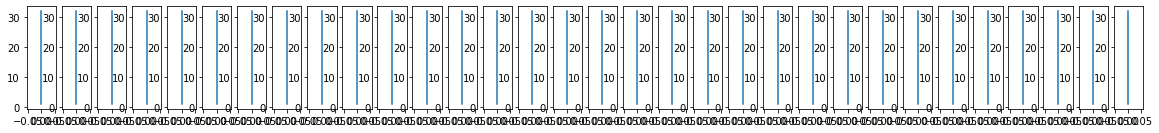

In [11]:
# check the data distribution
plot_distribution(images)

From above results we can tell that the maximum value of images is 1, the minimum value of data is 0. Moreover, the data
distribution is relatively equal to Gaussian distribution. Therefore, we don't have to do the data normalization.

#### Split the dataset

Normally, if the nubmer of samples in dataset isn't beyond million, we split the data to train, validation, and test with rate of 6:2:2, if we have a million level dataset, then we normally split the datasets with rate of 98:1:1. In this step, we will split the data as train set, validation set, and test set where the rate is 6:2:2, the traininig set containing contains 13792 samples, validation and testing set are both containing 4597 samples. In this case, we have enough sample for traininig and validation, at the same time, we have to enough sample to verify the generalization of model on the testing set.

In [13]:
class AsDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def random_split(self, rate):
        """
        take the rate(type:list) as input, then return same type split subsets based on the rate, the number of subsets
        depends on the length of rate. The sum of all numbers in rate must be 10.
        i.g list = [2, 2, 2, 2, 2], the function will return 5 subsets, length of subset_1: subset_2 : ... : subset_5 = 2: 2: 2: 2: 2.
            list = [8, 2], the function will return 2 subsets, length of subset_1 : subset_2 = 8: 2
        """
        lengths = [int(round(len(self) * i / 10)) for i in rate]
        sets =  torch.utils.data.random_split(self, lengths)
        # return [s.dataset  for s in sets]
        return sets

In [14]:
img_dataset = AsDataset(images, labels)
train_set, val_set, test_set = img_dataset.random_split([6, 2, 2])

# print the length of split dataset
print(f'Length of tranining set: {len(train_set)}')
print(f'Length of validation set: {len(val_set)}')
print(f'Length of testing set: {len(test_set)}')

Length of tranining set: 13792
Length of validation set: 4597
Length of testing set: 4597


### Task 2 - B: Training and justification

1. Train 2 different models (CNN and MLP), prediction: average yield
2. Explain why choose the model, are they suitable
3. set up hyper parameters, explain why to choose them
4. Expalain training tricks (learning decay, early stop)
5. Plot the error

In this task, we will predict the average yeild based on the given arrays that are actually representing infrared image. The prediction is a value representing the yield. Therefore, we can abstract it as a regression problem.

In MLP, each neuron on the first layer takes a feature of the input data that share same dimensionality, the first layer will calculate the weight and bias according to the features, then the subsequent layer will calculate the weight and bais based on the output of its upper layer, then the next layer will do the same thing...., finally, we will get more accurate weight and bais which can represent prediction based on the input data. In PyTorch, this layer is defined as `nn.Linear()`. 

In CNNs, compare with MLPs, MLPs learn the global features of input (ig. to an image, MLP learns all the modes of the image about the pixel. However, CNNs learn only learn partial features of the image according to its "kernel", the kernel is like a 2D window with a fixed height and width, the window will side on the image, it is like a scanner scanning the image to get the features, the feature CNNs get is leart from the window. Because of the translaion invariant and spatial hierarchies of patterns in visual world, if the CNN learnt the features at somewhere of the image, when the feature appear at other place of the image, CNN can also recogonize it, but for MLP, if the feature appears on a new position of the image, then the network has to learn this mode over again. Moreover, the CNN layer can learn bigger mode from the output of its prior layer so CNN can learn more and more complicated and abstracted mode. In PyTorch, CNN layer for 2D image is defined as `nn.Conv2D()`. 


Overall, we will build up two models to predict the average yield. One of the models is Multilayer Perception(MLP), the other one is Convolutional Network(ConvNet). Both of them are feasible for this task.


In [15]:
# intall a third-part module so that we can check the summary information of model
!pip install torchinfo

Because each sample in our dataset is a 9-dimentional image, so when we send the sample to our model, we have to flatten it to a 1-dimentional array as we know each layer in MLP can only process the linear data.

In [16]:
from torch import nn

# build our MLP model
class MLP(nn.Module):
    '''MLP model to solve our task based on the data shape'''
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 9, 576),
            nn.ReLU(),
            # nn.Linear(64, 32),
            # nn.ReLU(),
            nn.Linear(576, 288),
            nn.ReLU(),
            nn.Linear(288, 144),
            nn.ReLU(),
            nn.Linear(144, 72),
            nn.ReLU(),
            nn.Linear(72, 1),
            # nn.ReLU(),
            # nn.Linear(36, 1)
        )

    def forward(self, x):
        """forward pass"""
        return self.layers(x)

In CNNs, because everytime the kernel slides on a 2-D surface of image, it will get the featuers of image with size [kernal_height, kernal_width, channel], therefore, we don't have to flatten the image. However, as it is a regression task and we still have to calculate the weight and bais of features, we have to flatten the CNN layer to a 1-D layer, then sending to Linear layer.

In [18]:
# build our ConvNet model
class ConvNet(nn.Module):
    '''
    ConvNet model to solve our task based on the processed dataset. 
    We define the Conv2D layers and Dense layers separately for the convenience of code refactor 
    '''
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name
        self.conv_layers = nn.Sequential(
            nn.Conv2d(9, 18, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(18, 9, kernel_size=3),
            nn.ReLU(),
            
            nn.Flatten(),
        )
        self.fc = nn.Sequential(
            nn.Linear(28 * 28 * 9, 576),
            nn.ReLU(),
            nn.Linear(576, 288),
            nn.ReLU(),
            nn.Linear(288, 144),
            nn.ReLU(),
            nn.Linear(144, 72),
            nn.ReLU(),
            nn.Linear(72, 1),
        )

    def forward(self, x):
        '''forward pass'''
        out = self.conv_layers(x)
        return self.fc(out)

Let's initialize our model defined above and check the summary information. We assuming that we will send 100 samples (the shape is [9, 32, 32]) to the model in each batch.

In [19]:
from torchinfo import summary
import torch

mlp = MLP('mlp_model')
summary(mlp, input_size=(100, 9, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      --                        --
├─Sequential: 1-1                        [100, 1]                  --
│    └─Flatten: 2-1                      [100, 9216]               --
│    └─Linear: 2-2                       [100, 576]                5,308,992
│    └─ReLU: 2-3                         [100, 576]                --
│    └─Linear: 2-4                       [100, 288]                166,176
│    └─ReLU: 2-5                         [100, 288]                --
│    └─Linear: 2-6                       [100, 144]                41,616
│    └─ReLU: 2-7                         [100, 144]                --
│    └─Linear: 2-8                       [100, 72]                 10,440
│    └─ReLU: 2-9                         [100, 72]                 --
│    └─Linear: 2-10                      [100, 1]                  73
Total params: 5,527,297
Trainable params: 5,527,297
Non-trainable

In [20]:
convnet = ConvNet('cnn_model')
summary(convnet, input_size=(100, 9, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  --                        --
├─Sequential: 1-1                        [100, 7056]               --
│    └─Conv2d: 2-1                       [100, 18, 30, 30]         1,476
│    └─ReLU: 2-2                         [100, 18, 30, 30]         --
│    └─Conv2d: 2-3                       [100, 9, 28, 28]          1,467
│    └─ReLU: 2-4                         [100, 9, 28, 28]          --
│    └─Flatten: 2-5                      [100, 7056]               --
├─Sequential: 1-2                        [100, 1]                  --
│    └─Linear: 2-6                       [100, 576]                4,064,832
│    └─ReLU: 2-7                         [100, 576]                --
│    └─Linear: 2-8                       [100, 288]                166,176
│    └─ReLU: 2-9                         [100, 288]                --
│    └─Linear: 2-10                      [100, 144]                

In the next six code cells, we are going to define three functions, the usage of each function has been written in the comment of code.

In [21]:
def fit(model, trainloader, loss_func, optim, device):
    """fit the model for one epoch"""
    device = device
    fit_trainloader = trainloader
    model.train()

    train_loss = 0.0
    counter = 0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(fit_trainloader, 0):
        counter += 1
        inputs, targets = data[0].to(device), data[1].to(device)  # get inputs and targets

        optim.zero_grad()   # zero the optimizer
        outputs = model(inputs)   # perform forward pass
        loss = loss_func(outputs, targets)  # compute loss

        train_loss += loss.item()

        loss.backward()     # perform backward pass
        optim.step()    # perform optimization

    train_avg_loss = train_loss / counter

    # return train_avg_loss, train_avg_acc
    return train_avg_loss

In [22]:
def validate(model, val_loader, loss_func, device):
    """evaluate the model for one time"""
    device = device
    val_loader = val_loader
    counter = 0
    val_loss = 0
    model.eval()

    # Iterate over the DataLoader for validation data
    with torch.no_grad():
        for _, data in enumerate(val_loader, 0):
            counter += 1
            inputs, targets = data[0].to(device), data[1].to(device)

            outputs = model(inputs)

            loss = loss_func(outputs, targets)
            val_loss += loss.item()

        val_avg_loss = val_loss / counter

        return val_avg_loss

In [23]:
def save_model(model):
    """save the model into current work directory"""
    save_path = os.path.join(os.getcwd(), model.model_name+'.pth')
    torch.save(model, save_path)

In [24]:
class LRScheduler:
    """
    Learning rate scheduler. If the validation loss does not decrease for the given number of 'patience'  epochs,
    then the learning rate will decrease by given 'factor'.
    """

    def __init__(self, optimizer, patience=5, min_lr=1e-6, factor=0.5):
        """
        new_lr = old_lr * factor
        :param optimizer: the optimizer we are using
        :param patience: how many epochs to wait before updating the lr
        :param min_lr: least lr value to reduce to while updating
        :param factor: factor by which the lr should be updated
        """
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor

        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            patience=self.patience,
            factor=self.factor,
            min_lr=self.min_lr,
            verbose=True
        )

    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

In [25]:
class EarlyStopping:
    """
    Early stopping to stop the training when the loss does not improve after certain epochs.
    """

    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is not improving
        :param min_delta: minimum difference between new loss and old loss for new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # reset the counter if validation loss improves
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early Stopping')
                self.early_stop = True

In [27]:
import time

def train(model, epochs, train_set, val_set, batch_size, loss_func, optim, device, save=False, opt=None):

    train_loss, val_loss = [], []
    model = model
    
    train_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
    
    start = time.time()
    print(summary(model, input_size=(batch_size, 9, 32, 32)))

    for epoch in range(epochs):
        print(f"Epoch: {epoch+1} of {epochs}")
        train_epoch_loss = fit(
            model=model,
            trainloader = train_loader,
            loss_func = mae_loss,
            optim = optim,
            device = device
        )
        
        val_epoch_loss = validate(
            model=model,
            val_loader=val_loader,
            loss_func = mae_loss,
            device=device
        )
        train_loss.append(train_epoch_loss)
        val_loss.append(val_epoch_loss)

        # lr_scheduler
        if opt == "lr_scheduler":
            lr_scheduler = LRScheduler(optim)
            lr_scheduler(val_epoch_loss)

        # early stopping
        elif opt == "early_stopping":
            early_stopping(val_epoch_loss)
            if early_stopping.early_stop:
                break

        print(f"\tTrain loss: {train_epoch_loss:.8f}\tVal loss: {val_epoch_loss:.8f}")
    if save:
        save_model(model)
        
    end = time.time()
    print(f"Training time: {(end-start)/60:.3f} minutes")
    return train_loss, val_loss

Then we will define loss function, optimizer, the device where we are going to train our model (We always train the model on GPU if the machine has as it's much faster than CPU).

In [28]:
# declare which will hold the device we're training on (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"computation device: {device}\n")

# Set fixed random number seed
torch.manual_seed(42)

# Put our models into the device.
convnet.to(device)
mlp.to(device)

# Define the loss function and optimizer
mae_loss = nn.L1Loss()
mse_loss = nn.MSELoss()

def rmse_loss(y, y_hat):
    mse = nn.MSELoss()
    return torch.sqrt(mse(y, y_hat))
rmse_loss = rmse_loss

# Define the optimizer
lr = 0.01
weight_decay = 0.001
conv_optimizer = torch.optim.Adam(convnet.parameters(), lr=lr, weight_decay=weight_decay)
mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr=lr, weight_decay=weight_decay)

computation device: cuda



In the next, we will start to fit the model of MLP and CNN. In the draft version of this experiment, we found out it would be so long to overfit the model, so we adopt the training trick of `lr_schedular` instead of `early_stopping`. 

In [29]:
mlp_history = train(
    model=mlp,
    epochs=200,
    train_set = train_set,
    val_set = val_set,
    batch_size = 1500,
    loss_func = mae_loss,
    optim = mlp_optimizer,
    device = device,
    save = True,
    opt = 'lr_scheduler'
)

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      --                        --
├─Sequential: 1-1                        [1500, 1]                 --
│    └─Flatten: 2-1                      [1500, 9216]              --
│    └─Linear: 2-2                       [1500, 576]               5,308,992
│    └─ReLU: 2-3                         [1500, 576]               --
│    └─Linear: 2-4                       [1500, 288]               166,176
│    └─ReLU: 2-5                         [1500, 288]               --
│    └─Linear: 2-6                       [1500, 144]               41,616
│    └─ReLU: 2-7                         [1500, 144]               --
│    └─Linear: 2-8                       [1500, 72]                10,440
│    └─ReLU: 2-9                         [1500, 72]                --
│    └─Linear: 2-10                      [1500, 1]                 73
Total params: 5,527,297
Trainable params: 5,527,297
Non-trainable

In [30]:
conv_history = train(
    model=convnet,
    epochs=200,
    train_set = train_set,
    val_set = val_set,
    batch_size = 1500,
    loss_func = mae_loss,
    optim = conv_optimizer,
    device = device,
    save = True,
    opt='lr_scheduler'
)

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  --                        --
├─Sequential: 1-1                        [1500, 7056]              --
│    └─Conv2d: 2-1                       [1500, 18, 30, 30]        1,476
│    └─ReLU: 2-2                         [1500, 18, 30, 30]        --
│    └─Conv2d: 2-3                       [1500, 9, 28, 28]         1,467
│    └─ReLU: 2-4                         [1500, 9, 28, 28]         --
│    └─Flatten: 2-5                      [1500, 7056]              --
├─Sequential: 1-2                        [1500, 1]                 --
│    └─Linear: 2-6                       [1500, 576]               4,064,832
│    └─ReLU: 2-7                         [1500, 576]               --
│    └─Linear: 2-8                       [1500, 288]               166,176
│    └─ReLU: 2-9                         [1500, 288]               --
│    └─Linear: 2-10                      [1500, 144]               

We will write two functions, the one is to plot the loss values during the training/validation/testing process, the other one is test function.

In [31]:
def loss_plot(history, epochs):
    train_loss = history[0]
    val_loss = history[1]
    plt.plot(range(1, epochs+1), train_loss, label="Train Loss")
    plt.plot(range(1, epochs+1), val_loss, label="Val Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training loss VS. Validation loss')
    plt.legend()

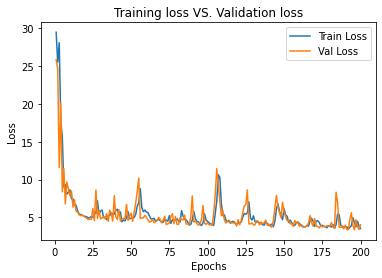

In [32]:
loss_plot(mlp_history, 200)

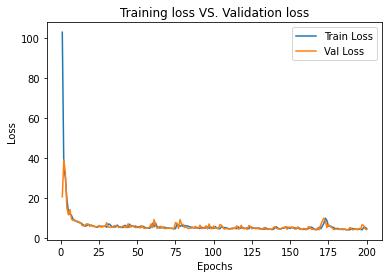

In [33]:
loss_plot(conv_history, 200)

In [34]:
def model_test(model_path, test_set, loss_func, batch_size, device):
    # load the model
    model = torch.load(model_path)
    model.eval()
    
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
    
    avg_test_loss = validate(model, test_loader, loss_func, device)
    
    print(f'The test loss is: {avg_test_loss:.4f}')

In [35]:
# test mlp
model_test('mlp_model.pth', test_set, mae_loss, 1000, device)

The test loss is: 5.0598


In [36]:
# test cnn
model_test('cnn_model.pth', test_set, mae_loss, 1000, device)

The test loss is: 4.9000


### Task 2 - C: Cross validation

In [37]:
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.model_selection import KFold

In [38]:
def reset_weights(m):
    """
    Try resetting model weights to aovid weight leakage.
    """
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

k_folds = 5,
We decide to train 40 epochs in each fold

In [60]:
def k_fold_train(model, dataset, epochs, optimizer, batch_size, loss_func, device, k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    results = {}
    test_loaders = []
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        print(f'FOLD {fold}')
        print('----------------------------------------')

        # Sample train and test datasets based on the index of dataset.
        tr_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
        ts_sampler = torch.utils.data.SubsetRandomSampler(test_ids)

        train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=tr_sampler)
        test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=ts_sampler)
        test_loaders.append(test_loader)

        # Initialize model
        model = model
        model.apply(reset_weights)
        # Initialize optimizer
        optimizer = optimizer
        # Initialize loss function
        loss_func = loss_func

        # Training process
        for epoch in range(epochs):
            avg_epoch_loss = fit(model, train_loader, loss_func, optimizer, device)
            # implement lr_schedular
#             lr_scheduler = LRScheduler(optimizer)
#             lr_scheduler(avg_epoch_loss)
            if epoch % 20 == 19:
                print(f'Epoch <{epoch+1}/{epochs}>, Train_Loss: {avg_epoch_loss:.4f}')
        print('Training process has finished. Saving trained model')
        print('Starting testing')
        # Save the model
        save_path = f'./{fold}-fold-'+model.model_name+'.pth'
        torch.save(model, save_path)

        # Evaluate the model
        evl_model = torch.load(save_path)
        avg_evl_loss = validate(evl_model, test_loader, loss_func, device)
        print(f"{fold}-fold evl_loss: {avg_evl_loss:.4f}\n")
        results[fold] = avg_evl_loss
    print(f'K-fold cross validation results for {k_folds}')
    print('------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'fold-{key}: {value}')
        sum+= value
    fold_avg = sum / k_folds
    print(f'Average: {fold_avg:.4f}')
    
    return test_loaders

In [61]:
# declare which will hold the device we're training on (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"computation device: {device}\n")

# Put our models into the device.
kf_convnet = ConvNet('kf_convnet').to(device)

kf_mlp = MLP('kf_mlp').to(device)

# Define the loss function and optimizer
mae_loss = nn.L1Loss()
mse_loss = nn.MSELoss()

def rmse_loss(y, y_hat):
    mse = nn.MSELoss()
    return torch.sqrt(mse(y, y_hat))
rmse_loss = rmse_loss

# Define the optimizer
lr = 0.001
weight_decay = 0.001
kf_conv_optimizer = torch.optim.Adam(kf_convnet.parameters(), lr=lr, weight_decay=weight_decay)
kf_mlp_optimizer = torch.optim.Adam(kf_mlp.parameters(), lr=lr, weight_decay=weight_decay)

computation device: cuda



In [62]:
mlp_test_loaders = k_fold_train(kf_mlp, img_dataset, 200, kf_mlp_optimizer, 1500, mae_loss, device, 5)

FOLD 0
----------------------------------------
Reset trainable parameters of layer = Linear(in_features=9216, out_features=576, bias=True)
Reset trainable parameters of layer = Linear(in_features=576, out_features=288, bias=True)
Reset trainable parameters of layer = Linear(in_features=288, out_features=144, bias=True)
Reset trainable parameters of layer = Linear(in_features=144, out_features=72, bias=True)
Reset trainable parameters of layer = Linear(in_features=72, out_features=1, bias=True)
Epoch <20/200>, Train_Loss: 3.9144
Epoch <40/200>, Train_Loss: 3.1931
Epoch <60/200>, Train_Loss: 3.0123
Epoch <80/200>, Train_Loss: 2.7348
Epoch <100/200>, Train_Loss: 2.4241
Epoch <120/200>, Train_Loss: 2.4140
Epoch <140/200>, Train_Loss: 2.3034
Epoch <160/200>, Train_Loss: 2.2557
Epoch <180/200>, Train_Loss: 2.0513
Epoch <200/200>, Train_Loss: 1.8662
Training process has finished. Saving trained model
Starting testing
0-fold evl_loss: 3.9112

FOLD 1
----------------------------------------
Re

In [63]:
cnn_test_loaders = k_fold_train(kf_convnet, img_dataset, 200, kf_conv_optimizer, 1500, mae_loss, device, 5)

FOLD 0
----------------------------------------
Reset trainable parameters of layer = Conv2d(9, 18, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(18, 9, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=7056, out_features=576, bias=True)
Reset trainable parameters of layer = Linear(in_features=576, out_features=288, bias=True)
Reset trainable parameters of layer = Linear(in_features=288, out_features=144, bias=True)
Reset trainable parameters of layer = Linear(in_features=144, out_features=72, bias=True)
Reset trainable parameters of layer = Linear(in_features=72, out_features=1, bias=True)
Epoch <20/200>, Train_Loss: 5.1813
Epoch <40/200>, Train_Loss: 4.5013
Epoch <60/200>, Train_Loss: 4.1612
Epoch <80/200>, Train_Loss: 3.9449
Epoch <100/200>, Train_Loss: 3.6430
Epoch <120/200>, Train_Loss: 3.4991
Epoch <140/200>, Train_Loss: 3.1632
Epoch <160/200>, Train_Loss: 2.9491
Epoch <180/200>, Train_Loss: 2.7183
Epoch 

### Task 2 - D: Inference

1. Get the best performance model from previous training
2. plot tables/plots (get the average yield)
3. calculate MAE, MSE, RMSE

In [80]:
def rmse_loss(y, y_hat):
        mse = nn.MSELoss()
        return torch.sqrt(mse(y, y_hat))

def multi_test(model_path, test_loader, device):
    mae_loss = nn.L1Loss()
    mse_loss = nn.MSELoss()
    
    model = torch.load(model_path)
    model.eval()
    model.to(device)
    
    counter, mae_total, mse_total, rmse_total = 0, 0.0, 0.0, 0.0
    # test_loader = torch.utils.data.DataLoader(val_set, batch_size=5000, shuffle=True, num_workers=1)
    predicts_a = np.empty((1,1))    # initialize a empty variable to save the predicts
    targets_a = np.empty((1,1))     # initialize a empty variable to save the targets
    for i, data in enumerate(test_loader):
        counter += 1
        inputs, targets = data[0].to(device), data[1].to(device)
        
        predicts = model(inputs)
        
        mae = mae_loss(predicts, targets)
        mse = mse_loss(predicts, targets)
        rmse = rmse_loss(predicts, targets)
        
        mae_total += mae.item()
        mse_total += mse.item()
        rmse_total += rmse.item()

        predicts_a = np.append(predicts_a, predicts.cpu().detach().numpy())
        targets_a = np.append(targets_a, targets.cpu().detach().numpy())
    print(f"MAE: {(mae_total/counter):.4f}\tMSE: {(mse_total/counter):.4f}\tRMSE: {(rmse_total/counter):.4f}")
    
    x = range(1, len(targets_a)+1)
    plt.scatter(x, targets_a, label="targets")
    plt.scatter(x, predicts_a, label="predicts")
    plt.title("Predictions VS. Targets")
    plt.xlabel("Xth Sample")
    plt.ylabel("Average yield")
    plt.legend()

In [65]:
cnn_test_loaders

MAE: 3.4825	MSE: 23.4711	RMSE: 4.8381


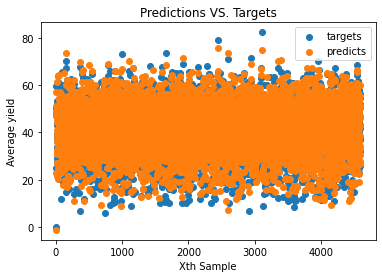

In [81]:
multi_test(
    model_path='./0-fold-kf_convnet.pth', 
    test_loader=cnn_test_loaders[0], 
    device=device
)